### Document Analysis Graph
Alfred at your service. As Mr. Wayne’s trusted butler, I’ve taken the liberty of documenting how I assist Mr Wayne with his various documentary needs. While he’s out attending to his… nighttime activities, I ensure all his paperwork, training schedules, and nutritional plans are properly analyzed and organized.

Before leaving, he left a note with his week’s training program. I then took the responsibility to come up with a menu for tomorrow’s meals.

For future such events, let’s create a document analysis system using LangGraph to serve Mr. Wayne’s needs. This system can:

Process images document
Extract text using vision models (Vision Language Model)
Perform calculations when needed (to demonstrate normal tools)
Analyze content and provide concise summaries
Execute specific instructions related to documents
The Butler’s Workflow
The workflow we’ll build follows this structured schema:

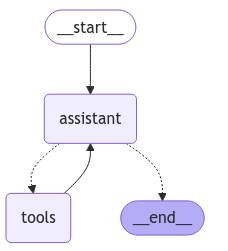

In [30]:
import os
import base64
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from os import getenv
from dotenv import load_dotenv
load_dotenv()

True

Test code call

In [62]:

vision_llm = ChatOpenAI(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    model="google/gemma-3-4b-it:free"
)
# Example usage
response = vision_llm.invoke("What NFL team won the Super Bowl in the year Justin Bieber was born?")
print(response.content)

Justin Bieber was born in 1994. The San Francisco 49ers won Super Bowl XXIX in 1995. 

So the answer is the **San Francisco 49ers**.


Code to extract text from images

In [63]:
def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """

    all_text = ""

    # read image as bytes and encode as base 64

    try:
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()
        
        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        response = vision_llm.invoke(message)

        # append extracted text

        all_text += response.content + "\n\n"

        return all_text.strip()
    
    except Exception as e:
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""
    
def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

tools = [
    divide,
    extract_text
]

llm = ChatOllama(model="kimi-k2:1t-cloud")

llm_with_tools = llm.bind_tools(tools)

Let's test the tool

In [64]:
extract_text(img_path=r"waynes_note\Batman_training_and_meals.png")

"TRAINING SCHEDULE\nFor the week of 2/20-2/26\n\nSUNDAY 2/20\nMORNING\n30 minute meditation\n30 minute target practice\n30 minutes heavy bag\n\nEVENING\nclean and jerk 11-3 rep sets 262 lbs.\n5 sets metabolic conditioning\n10 mile run\n21 kettlebell swings\n30 minutes flexibility\n30 minutes spinning\n\nMONDAY 2/21\nMORNING\n30 minute meditation\n30 traditional martial arts (focus on Japanese forms)\nEVENING\n5 sets 20 foot rope climb\n30 minutes rhythmic yoga (work on muscle ups in particular)\nhigh box jumps - 12 rep sets\n60 rep squats\n60 rep lunges\n30 minutes flexibility\n30 minute target practice\n\nTUESDAY 2/22\nMORNING\n30 minutes yoga\n30 minute meditation\n30 minutes heavy bag\n\nFRIDAY 2/26\nMORNING\n30 minute jog\n30 minute meditation\nEVENING\nclean and jerk 11-3 rep sets 282 lbs.\n5 sets metabolic conditioning\n10 mile run\n21 kettlebell swings\n30 minutes flexibility\n30 minutes spinning\n\nSATURDAY 2/26\nMORNING\n30 minute yoga\n30 minutes jog\n\nEVENING\nsquats - 30 r

Let's create our LLM and prompt it with the overall desired agent behavior.

In [65]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The input document
    input_file: Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [66]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


def assistant(state: AgentState):
    # System message
    textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image = state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computatio without provided tools :\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded images is : {image}")

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}

We define a `tools` node with our list of tools.

The `assistant` node is just our model with bound tools.

We create a graph with `assistant` and `tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `tools` based on  whether the `assistant` calls a tool.

Now, we add one new step:

We connect the `tools` node *back* to the `assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

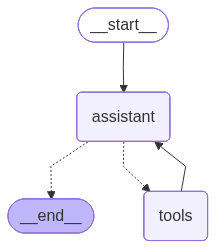

In [67]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these define how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [68]:
messages = [HumanMessage(content="Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages, "input_file": None})

In [69]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================

I'll divide 6790 by 5 for you.
Tool Calls:
  divide (77d938ec-ce82-4f4d-83af-5eb4eeb53397)
 Call ID: 77d938ec-ce82-4f4d-83af-5eb4eeb53397
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

6790 ÷ 5 = 1358


## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner left in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [70]:
messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?")]
messages = react_graph.invoke({"messages": messages, "input_file": r"waynes_note\Batman_training_and_meals.png"})

In [71]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?
================================== Ai Message ==================================

I'll extract the text from the image to see what Mr. Wayne has planned for the dinner menu.
Tool Calls:
  extract_text (71ac180e-c7f7-4243-a96c-e830a9cae647)
 Call ID: 71ac180e-c7f7-4243-a96c-e830a9cae647
  Args:
    img_path: waynes_note\Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute meditation
30 minute target practice
30 minutes heavy bag

EVENING
clean and jerk 11-3 rep sets 262 lbs.
5 sets metabolic conditioning
10 mile run
21 kettlebell swings
30 minutes flexibility
30 minutes spinning

MONDAY 2/21
MORNING
30 minute meditation
30 traditional

================================[1m Human Message [0m=================================

According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?
==================================[1m Ai Message [0m==================================

I'll extract the text from the image to see what Mr. Wayne has planned for the dinner menu.
Tool Calls:
  extract_text (71ac180e-c7f7-4243-a96c-e830a9cae647)
 Call ID: 71ac180e-c7f7-4243-a96c-e830a9cae647
  Args:
    img_path: waynes_note\Batman_training_and_meals.png
=================================[1m Tool Message [0m=================================
Name: extract_text

TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute meditation
30 minute target practice
30 minutes heavy bag

EVENING
clean and jerk 11-3 rep sets 262 lbs.
5 sets metabolic conditioning
10 mile run
21 kettlebell swings
30 minutes flexibility
30 minutes spinning

MONDAY 2/21
MORNING
30 minute meditation
30 traditional martial arts (focus on Japanese forms)
EVENING
5 sets 20 foot rope climb
30 minutes rhythmic yoga (work on muscle ups in particular)
high box jumps - 12 rep sets
30 rep sets
30 rep sets
30 minutes flexibility
30 minute target practice

TUESDAY 2/22
MORNING
30 minutes yoga
30 minute meditation
30 minutes heavy bag

FRIDAY 2/26
MORNING
30 minute jog
30 minute meditation

EVENING
clean and jerk 11-3 rep sets 282 lbs.
5 sets metabolic conditioning
10 mile run
21 kettlebell swings
30 pull ups
30 minutes flexibility
30 minutes spinning

SATURDAY 2/26
MORNING
30 minute yoga
30 minutes jog

EVENING
squats - 30 rep sets 528 lbs.
squats - 30 rep sets 528 lbs.
push-ups - 50 reps
50 reps
14 minute timer
30 minutes pommel horse
30 minute heavy bag
3 mile swim

An effort to ensure the all-
wrapped Bark Knight to bake
the oil of his body, studies and
actually changes a reasonable
amount of sadness. I have taken
the liberty of changing a few
for today's schedule, as it is
my hope that these cleverly
prepared exercises will allow the
date of their professions, resting cold
and vouchsed on a computer console.

Breakfast
six poached eggs laid over artichoke bottoms with a sage pesto sauce
thinly sliced baked ham
mixed organic fresh fruit bowl
freshly squeezed orange juice
organic grass-fed milk
4 grams branched-chain amino acid
2 grams fish oil

Lunch
local salmon with a ginger glaze
organic asparagus with lemon garlic dusting
Yanone with grissini dots
2 grams fish oil
==================================[1m Ai Message [0m==================================

Looking at the note from Mr. Wayne, I can see the breakfast and lunch menus, but unfortunately the dinner menu is not included in this document. The note only shows:

**Breakfast:**
- six poached eggs laid over artichoke bottoms with a sage pesto sauce
- thinly sliced baked ham
- mixed organic fresh fruit bowl
- freshly squeezed orange juice
- organic grass-fed milk
- 4 grams branched-chain amino acid
- 2 grams fish oil

**Lunch:**
- local salmon with a ginger glaze
- organic asparagus with lemon garlic dusting
- Yanone with grissini dots
- 2 grams fish oil

The dinner menu items are not listed in this training schedule and meal plan document.
